In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel('T200-Public-Performance-Data-10-20V-September-2019.xlsx', sheet_name='16 V') 
df.head()

,PWM (µs),RPM,Current (A),Voltage (V),Power (W),Force (Kg f),Efficiency (g/W)
0,1100,3464.713333,24.298333,16,388.773333,-4.069476,10.467466
1,1104,3468.010000,24.300000,16,388.800000,-4.050577,10.418150
2,1108,3449.070000,23.780000,16,380.480000,-4.023361,10.574435
3,1112,3421.120000,23.250000,16,372.000000,-3.964394,10.656973
4,1116,3409.950000,22.640000,16,362.240000,-3.900891,10.768803


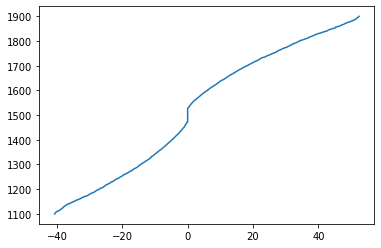

In [ ]:
plt.plot(10*df[' Force (Kg f)'], df[' PWM (µs)'])


(186, 7)
(201, 7)
(93, 7)
(93, 7)
(186,)
(186,)


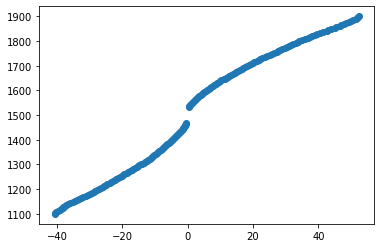

In [ ]:
#linear interpolation (regression)
df0 = df[df[' Force (Kg f)']!=0] #filter the 0 on x axis
print(df0.shape)
print(df.shape)

pos_df = df0[df0[' Force (Kg f)']>0] #x>0
neg_df = df0[df0[' Force (Kg f)']<0] #x<0

print(pos_df.shape)
print(neg_df.shape)

y = np.array(df0[' PWM (µs)'].to_list())
x = 10*np.array(df0[' Force (Kg f)'].to_list())
print(y.shape)
print(x.shape)
plt.scatter(x,y)


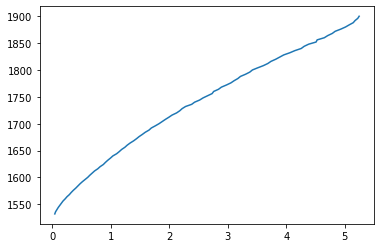

In [ ]:
plt.plot(pos_df[' Force (Kg f)'], pos_df[' PWM (µs)'])

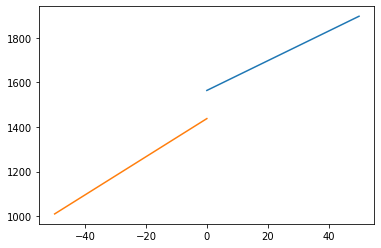

In [ ]:
def linear_interpolate(df):
    x = 10*np.array(df[' Force (Kg f)'].to_list())
    y = np.array(df[' PWM (µs)'].to_list())
    
    #LINE EQN Y = MX +C
    
    N = y.shape[0] #NUMBER OP DATAPOINT
    m = (N*np.sum(np.multiply(x,y)) - np.sum(x)*np.sum(y))/ (N*np.sum(np.square(x)) - (np.sum(x)**2))
    c = (np.sum(y)-m*np.sum(x))/N
    return m,c

m1,c1 = linear_interpolate(pos_df)

x1 = np.linspace(0.0,50.0, 1000)
y1 = m1*x1 + c1 
plt.plot(x1,y1)

m2,c2 = linear_interpolate(neg_df)
x2 = np.linspace(-50,0,1000)
y2 = m2*x2 + c2
plt.plot(x2, y2)


In [ ]:
#question 4,5,6 proportional controller

def p_control(kp=[5,5,5,5,5,5], state=[5,5,5,0,5,5], destination =[5,5,5,5,5,5], enable = [1,1,1,1,1,1], flotability = 0):
    if not len(kp)==len(state) and len(destination)==len(state):
        print(' error input')

    masked_kp = np.multiply(kp, enable)
    output = np.multiply(masked_kp,(np.array(destination)-np.array(state))) + np.array([0,0,flotability, 0, 0, 0])
    return output 

p_control()

array([ 0,  0,  0, 25,  0,  0])

In [ ]:
global int_error 
int_error = np.array([0, 0, 0, 0, 0, 0], dtype = 'float64')

def PI_control(Kp= [5,5,5,5,5,5] ,state = [5,5,5,5,5,5],destination = [5,5,5,5,5,5], Ki = [5,5,5,5,5,5], enable = [1,1,1,1,1,1], floatability = 0, dt = 0.001):
    global int_error
    P_control = p_control(Kp, state, destination, enable, floatability)
    error = np.array(destination) - np.array(state)
    int_error += error*dt
    output = P_control + int_error*Ki

    return output

PI_control()

array([0., 0., 0., 0., 0., 0.])

In [ ]:
global prev_error
prev_error = np.array([0, 0, 0, 0, 0, 0], dtype = 'float64')

def PID_control(Kp= [5,5,5,5,5,5] ,state = [5,5,5,5,5,5],destination = [5,5,5,5,5,5], Ki = [5,5,5,5,5,5], Kd = [5,5,5,5,5,5], enable = [1,1,1,1,1,1], floatability = 0, dt = 0.001):
    global prev_error

    pi_control = PI_control(Kp, state, destination, Ki, enable, floatability)
    error = np.array(destination) - np.array(state)
    diff_error = (error-prev_error)/dt
    output = pi_control + np.multiply(pi_control,Kd)
    prev_error = error
    return output

PID_control()

array([0., 0., 0., 0., 0., 0.])

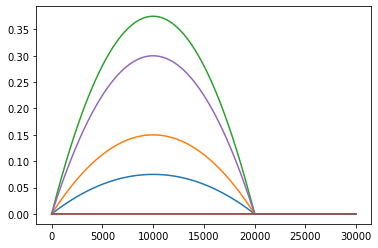

In [ ]:
def trajectory( t ,state_init=[5,5,5,5,5,5], state_final=[5,5,5,5,5,5], t_final=20, enable=[1,1,1,1,1,1]):
    # t = np.array(t)
    # t = t[t<=t_final]

    a2 = 3*(np.array(state_final) - np.array(state_init))/(t_final**2)
    a3 = -2*(np.array(state_final)-np.array(state_init))/(t_final**3)
    
    output = np.array(state_init).reshape(6,1) + np.multiply(np.reshape(a2, (6,1)), t**2) + np.multiply(np.reshape(a3, (6,1)), t**3)
    derivative = np.array(state_init).reshape(6,1) + 2*np.multiply(np.reshape(a2, (6,1)), t) + 3*np.multiply(np.reshape(a3, (6,1)), t**2)
    
    return output, derivative

def trajectory_gen(t_final=20, mission_time=30, state_init = [0,0,0,0,0,0], state_final=[1,2,5,0,4,0], dt=0.001):
    t = np.linspace(0, t_final, int(t_final/dt))
    
    traj, der = trajectory(t, state_init, state_final, t_final)

    t_steady = np.linspace(t_final, mission_time, int((mission_time-t_final)/dt))
    t_steady = t_steady[1:]
    N = t_steady.shape[0]
    aa = np.array(state_final).reshape((6,1))
    state_steady = np.multiply(np.array(state_final).reshape((6,1)), np.ones((6, N)))
    steady_state_der = np.multiply(np.array(state_final).reshape((6,1)), np.zeros((6, N)))

    return np.concatenate((traj, state_steady), axis =1), np.concatenate((der, steady_state_der), axis =1) 

# t_final = 
# t = np.linspace(0, t_final, int(t_final/dt))
traj, der = trajectory_gen()
for i in range(6):
    plt.plot(der[i, :])

        

In [ ]:
a = np.reshape(np.array([1,2,3]),(3,1))
b = np.ones((6,7))


In [ ]:
a = np.linspace(1,10,10)
a[a<5]

array([1., 2., 3., 4.])